In [31]:
# Useful imports
import csv as csv
import pandas as pd
import numpy as np
import re
import operator

from matplotlib import pyplot as plt

% matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import cross_validation

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Load training data
titanic = pd.read_csv('./datasets/train.csv')

In [4]:
# Fill empty Age values with median
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())

In [5]:
print titanic['Sex'].unique()

# Replace all the occurences of male with the number 0.
titanic.loc[titanic['Sex'] == 'male', 'Sex'] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1

['male' 'female']


In [6]:
print titanic['Embarked'].unique()

# Fill empty values with the most popular one 'S'
titanic['Embarked'] = titanic['Embarked'].fillna('S')

# Set numeric codes
titanic.loc[titanic['Embarked'] == 'S', 'Embarked'] = 0
titanic.loc[titanic['Embarked'] == 'C', 'Embarked'] = 1
titanic.loc[titanic['Embarked'] == 'Q', 'Embarked'] = 2

['S' 'C' 'Q' nan]


In [7]:
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)

print scores.mean()

0.785634118967


In [8]:
# Parameter tuning

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=2)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)

print scores.mean()

0.81593714927


In [9]:
# Generating new features

# Generating a familysize column
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']

# The .apply method generates a new series
titanic['NameLength'] = titanic['Name'].apply(lambda x: len(x))

In [12]:
# A function to get the title from a name.
def get_title(name):
    
    # Use a regular expression to search for a title. 
    # Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search('([A-Za-z]+)\.', name)
    
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''

# Get all the titles and print how often each one occurs.
titles = titanic['Name'].apply(get_title)
print pd.value_counts(titles)

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Dr': 5, 'Rev': 6, 'Major': 7, 'Col': 7, 'Mlle': 8,\
                 'Mme': 8, 'Don': 9, 'Lady': 10, 'Countess': 10, 'Jonkheer': 10, 'Sir': 9, 'Capt': 7, 'Ms': 2}

for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print pd.value_counts(titles)

# Add to the title column.
titanic['Title'] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [17]:
# Generate family groups

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    
    # Find the last name by splitting on a comma
    last_name = row['Name'].split(',')[0]
    
    # Create the family id
    family_id = '{0}{1}'.format(last_name, row['FamilySize'])
    
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
            
        family_id_mapping[family_id] = current_id
        
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic['FamilySize'] < 3] = -1

# Print the count of each unique id.
print pd.value_counts(family_ids)

titanic['FamilyId'] = family_ids


-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


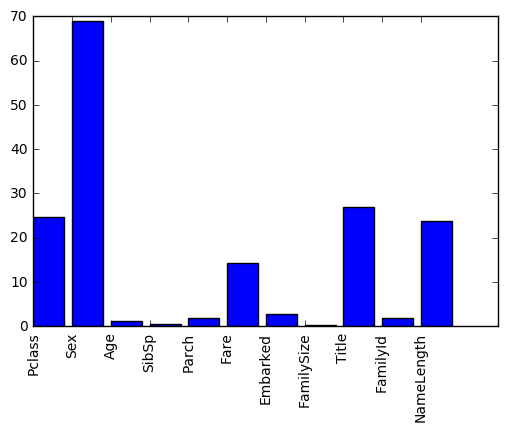

0.819304152637


In [26]:
# Choose the best features using "univariate feature selection"

predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title', 'FamilyId', 'NameLength']

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic['Survived'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ['Pclass', 'Sex', 'Fare', 'Title']

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic['Survived'], cv=kf)

print scores.mean()

In [33]:
# Ensembling

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", \
                                                                                "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    
    full_test_predictions = []
    
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
        
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print accuracy

0.819304152637


D:\Programs\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [34]:
# Generate predictions on the test dataset
titanic_test = pd.read_csv('./datasets/test.csv')

# Clean test data

# Median value is from training set, as we did the same there! The value must be the same
titanic_test['Age'] = titanic_test['Age'].fillna(titanic['Age'].median()) 
titanic_test.loc[titanic_test['Sex'] == 'male', 'Sex'] = 0
titanic_test.loc[titanic_test['Sex'] == 'female', 'Sex'] = 1

titanic_test['Embarked'] = titanic_test['Embarked'].fillna('S')
titanic_test.loc[titanic_test['Embarked'] == 'S', 'Embarked'] = 0
titanic_test.loc[titanic_test['Embarked'] == 'C', 'Embarked'] = 1
titanic_test.loc[titanic_test['Embarked'] == 'Q', 'Embarked'] = 2

# Median value is from test set, as train one has no null values
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].median()) 

# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)

# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8,\
                 "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}

for k,v in title_mapping.items():
    titles[titles == k] = v
    
titanic_test["Title"] = titles

# Check the counts of each unique title.
print pd.value_counts(titanic_test["Title"])

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
print family_id_mapping

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test['NameLength'] = titanic_test['Name'].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{"O'Sullivan0": 426, 'Mangan0': 620, 'Lindqvist1': 543, 'Denkoff0': 297, 'Rouse0': 413, 'Berglund0': 207, 'Meo0': 142, 'Arnold-Franchi1': 49, 'Chronopoulos1': 71, 'Skoog5': 63, 'Widener2': 329, 'Pengelly0': 217, 'Goncalves0': 400, 'Myhrman0': 626, 'Beane1': 456, 'Moss0': 104, 'Carlsson0': 610, 'Nicholls2': 136, 'Jussila1': 110, 'Jussila0': 483, 'Long0': 632, 'Wheadon0': 33, 'Connolly0': 261, 'Hansen2': 680, 'Stephenson1': 493, 'Davies0': 336, 'Silven2': 359, 'Vanden Steen0': 311, 'Astor1': 571, 'Patchett0': 480, 'Johanson0': 184, 'Coleridge0': 220, 'Christmann0': 87, 'Carter3': 340, 'Compton2': 665, 'Carter1': 226, 'Turkula0': 414, 'Hassab0': 558, 'Saad0': 566, 'Mellors0': 208, 'Mamee0': 36, 'Madsen0': 119, 'Anderson0': 395, 'Kraeff0': 42, 'Robbins0': 468, 'Lundahl0': 522, 'Gilinski0': 490, 'Porter0': 107, 'Sdycoff0': 352, 'Green0': 204, 'Bishop1': 263, 'Sinkkonen0': 603, 'Otter0':

In [36]:
# Prepating a submission with ensembled models

predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1

predictions = predictions.astype(int)

submission = pd.DataFrame({
    'PassengerId': titanic_test['PassengerId'],
    'Survived': predictions
})

# Save to file
submission.to_csv('./results/ensembledmodel-grboostinglogreg.csv', index=False)